### Importing all the required libraries

In [1]:
%matplotlib inline

import matplotlib

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix,classification_report
from LeNet import LeNet
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import cv2
import os
import sys

Using TensorFlow backend.


### Getting required parameter as input from user

In [2]:
dataset = "./data/training/"
modelName = "./model/LungCancer.model"
plot = "./output/lossGraph.jpeg"
matrixGraph = "./output/confusion_matrix.jpeg"

### Setting up the basic constants

In [3]:
epochs = 30
lr = 1e-3
batch_size = 32

### Reading dataset path and loading images

In [4]:
print("Loading images...")

data = []
labels = []

imagePaths = sorted(list(paths.list_images(dataset)))
random.seed(42)
random.shuffle(imagePaths)

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (40,40))
    image = img_to_array(image)
    data.append(image)
    
    label = imagePath[-7:-4]
    if label == "pos":
        label = 1
    else:
        label = 0
    labels.append(label)

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

Loading images...


### Displaying training image

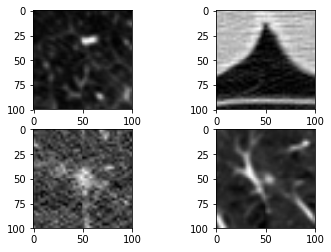

In [5]:
for i,images in enumerate(imagePaths[:4]):
    img = cv2.imread(images)
    img = cv2.resize(img,(100,100))
    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.grid(False)
plt.show()

### Splitting dataset into train-test

In [6]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

### One hot encoding the output

In [7]:
trainY = to_categorical(trainY, num_classes= len(labels))
testY = to_categorical(testY, num_classes= len(labels))

### Image generator for image preprocessing

In [8]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

### Training

In [9]:
print("Compiling model...")
model = LeNet.build(width=40, height=40, depth=3, classes=len(labels))
opt = Adam(lr=lr, decay=lr / epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print("Training network...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size), validation_data=(testX, testY), steps_per_epoch=len(trainX) // batch_size, epochs=epochs, verbose=1)


Compiling model...
Training network...
Epoch 1/30
68/68 [==============================] - 14s 201ms/step - loss: 1.0377 - acc: 0.6868 - val_loss: 0.4647 - val_acc: 0.7867
Epoch 2/30
68/68 [==============================] - 10s 152ms/step - loss: 0.4384 - acc: 0.8105 - val_loss: 0.4080 - val_acc: 0.8220
Epoch 3/30
68/68 [==============================] - 10s 147ms/step - loss: 0.4100 - acc: 0.8215 - val_loss: 0.3549 - val_acc: 0.8451
Epoch 4/30
68/68 [==============================] - 11s 156ms/step - loss: 0.3756 - acc: 0.8514 - val_loss: 0.3103 - val_acc: 0.8709
Epoch 5/30
68/68 [==============================] - 11s 155ms/step - loss: 0.3538 - acc: 0.8593 - val_loss: 0.3357 - val_acc: 0.8682
Epoch 6/30
68/68 [==============================] - 11s 167ms/step - loss: 0.3356 - acc: 0.8689 - val_loss: 0.2729 - val_acc: 0.8940
Epoch 7/30
68/68 [==============================] - 11s 165ms/step - loss: 0.2893 - acc: 0.8886 - val_loss: 0.2694 - val_acc: 0.8899
Epoch 8/30
68/68 [============

### Displaying the model

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 40, 40, 20)        1520      
_________________________________________________________________
activation_1 (Activation)    (None, 40, 40, 20)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 50)        25050     
_________________________________________________________________
activation_2 (Activation)    (None, 20, 20, 50)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 50)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
__________

### Evaluation

In [11]:
score = model.evaluate(testX, testY, verbose = 1)
print("The accuracy is :- %0.2f"%score[1])

736/736 [==============================] - 1s 1ms/step
The accuracy is :- 0.95


### Saving the model

In [12]:
print("Saving network...")
model.save(modelName)

Saving network...


### Graph of training loss and accuracy

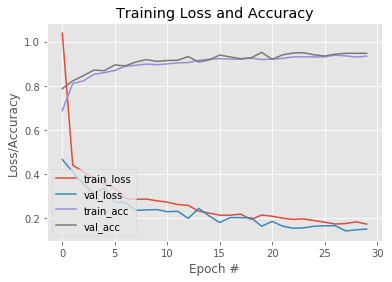

In [13]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plot)
plt.show()

###  Confusion matrix

In [14]:
def plot_confusion_matrix(cm,classes=[0,1],normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

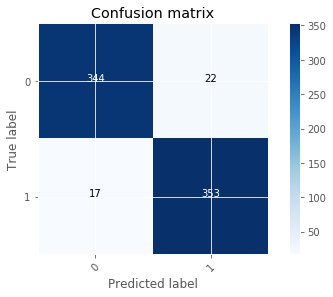

In [15]:
plt.figure()
predY = to_categorical(model.predict_classes(testX), num_classes= len(labels))
try:
    testY = [test[0] for test in testY]
    predY = [pred[0] for pred in predY]
except TypeError:
    pass
cm = confusion_matrix(testY,predY)
plot_confusion_matrix(cm)
plt.savefig(matrixGraph, bbox_inches='tight')
plt.show()

### Classification Report

In [16]:
print(classification_report(predY, testY))

             precision    recall  f1-score   support

        0.0       0.94      0.95      0.95       361
        1.0       0.95      0.94      0.95       375

avg / total       0.95      0.95      0.95       736

